            Timestamp   Price
Timestamp                    
1990-12-19 1990-12-19   96.05
1990-12-20 1990-12-20  104.30
1990-12-21 1990-12-21  109.07
1990-12-24 1990-12-24  113.57
1990-12-25 1990-12-25  120.09


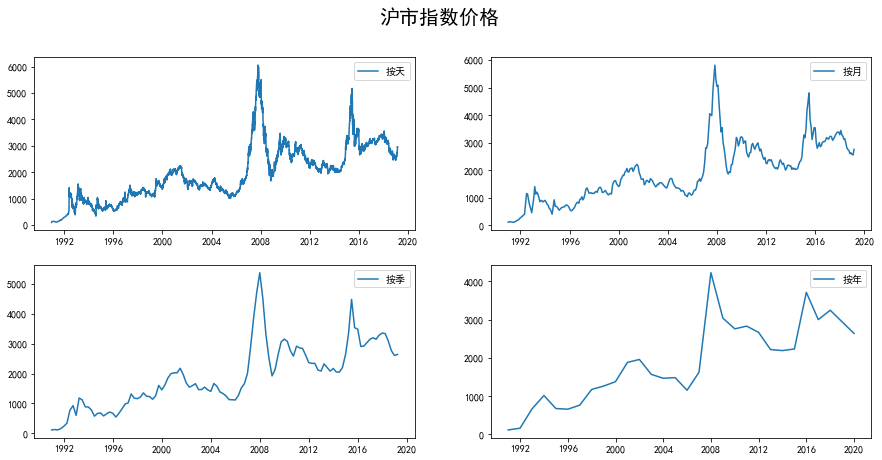

参数错误: (0, 2)
最优模型                               ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  339
Model:                     ARMA(2, 2)   Log Likelihood               -2208.110
Method:                       css-mle   S.D. of innovations            162.159
Date:                Sat, 30 Mar 2019   AIC                           4428.219
Time:                        17:27:02   BIC                           4451.175
Sample:                    12-31-1990   HQIC                          4437.367
                         - 02-28-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1841.5061    489.610      3.761      0.000     881.888    2801.124
ar.L1.Price     0.5137      0.130      3.959      0.000       0.259       0.768
ar.L2.Price     0.4501      0.

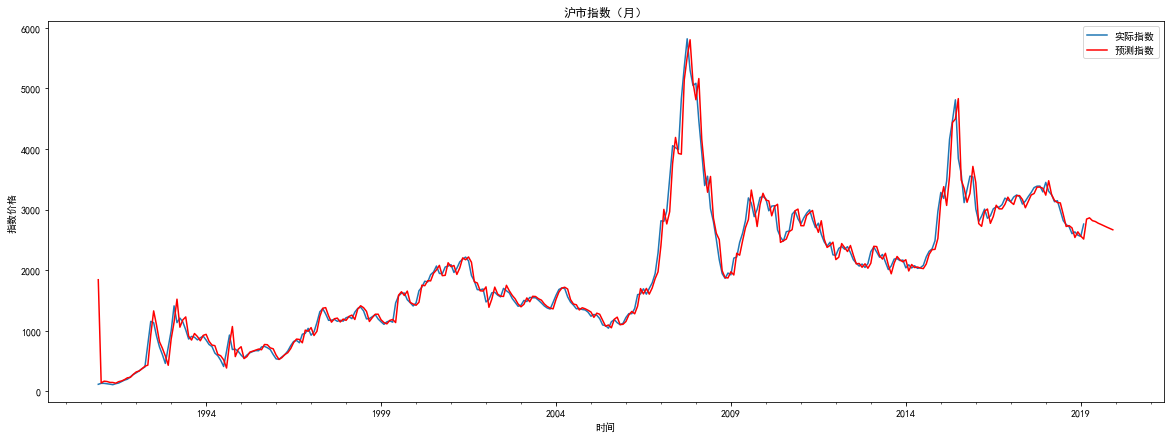

In [5]:
# -*- coding:utf-8 -*-
# 使用 ARMA 模型对沪市指数未来 10 个月（截止到 2019 年 12 月 31 日）的变化进行预测
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')

# 数据加载
df = pd.read_csv('./shanghai_1990-12-19_to_2019-2-28.csv')

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

# 数据探索
print(df.head())

# 按照月、季度、年统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()

# 按照天、月、季度、年来显示沪市指数的走势
fig = plt.figure(figsize = [15, 7])
plt.rcParams['font.sans-serif'] = ['SimHei']   # 用来正常显示中文标签
plt.suptitle('沪市指数价格', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label = '按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label = '按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label = '按季')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label = '按年')
plt.legend()
plt.show()

# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = [] 
best_aic = float('inf')   # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price, order = (param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

# 输出最优模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('最优模型', best_model.summary())

# 沪市指数预测
df_month2 = df_month[['Price']]
data_list = [datetime(2019, 3, 31), datetime(2019, 4, 30), datetime(2019, 5, 31), datetime(2019, 6, 30), 
            datetime(2019, 7, 31), datetime(2019, 8, 31), datetime(2019, 9, 30), datetime(2019, 10, 31), datetime(2019, 11, 30),
            datetime(2019, 12, 31)]
future = pd.DataFrame(index = data_list, columns = df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start = 0, end = 348)

# 沪市指数预测结果显示
plt.figure(figsize = (20, 7))
df_month2.Price.plot(label = '实际指数')
df_month2.forecast.plot(color = 'r', ls = '-', label = '预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数价格')
plt.show()